In [2]:
import pandas as pd
import numpy as np
import nltk
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
import re
import joblib
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('data.csv', on_bad_lines='skip')
df = df[['review_type', 'review_content']].rename(columns={'review_type': 'label', 'review_content': 'text'})
df['label'] = df['label'].map({'Fresh': 0, 'Rotten': 1})
df = df.dropna()
len(df)

1064211

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

In [6]:
vectorizer = TfidfVectorizer(max_features=20000, norm='l2', ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train_processed)
X_test_tfidf = vectorizer.transform(X_test_processed)

In [7]:
svd = TruncatedSVD(n_components=300, random_state=42)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [8]:
params = {
    'iterations': 15000,
    'learning_rate': 0.03,
    'depth': 5,
    'early_stopping_rounds': 200,
    'od_type':'Iter',
    'eval_metric': 'F1',
    'verbose': 500,
    'auto_class_weights': 'Balanced',
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
    'random_seed': 42
}

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = []
best_f1 = -np.inf  
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_svd, y_train)):
    print(f"\n Fold {fold+1}")
    X_tr, X_val = X_train_svd[train_idx], X_train_svd[val_idx]
    y_tr, y_val = y_train.to_numpy()[train_idx], y_train.to_numpy()[val_idx]
    
    model = CatBoostClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)
    
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    f1_scores.append(f1)
    print(f'F1 score: {f1:.4f}')

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        
print('\nAverage F1 on cross-validation:', np.mean(f1_scores))
print(f'Best F1 score: {best_f1:.4f}')


 Fold 1
0:	learn: 0.6036553	test: 0.6036396	best: 0.6036396 (0)	total: 110ms	remaining: 27m 33s
500:	learn: 0.6974741	test: 0.6946208	best: 0.6946208 (500)	total: 26.8s	remaining: 12m 54s
1000:	learn: 0.7108289	test: 0.7065809	best: 0.7066750 (999)	total: 52.5s	remaining: 12m 14s
1500:	learn: 0.7180395	test: 0.7121425	best: 0.7122865 (1491)	total: 1m 17s	remaining: 11m 39s
2000:	learn: 0.7233873	test: 0.7156126	best: 0.7156976 (1984)	total: 1m 42s	remaining: 11m 8s
2500:	learn: 0.7279139	test: 0.7185190	best: 0.7185929 (2494)	total: 2m 7s	remaining: 10m 37s
3000:	learn: 0.7321056	test: 0.7208074	best: 0.7208250 (2999)	total: 2m 32s	remaining: 10m 8s
3500:	learn: 0.7358765	test: 0.7229535	best: 0.7229910 (3498)	total: 2m 56s	remaining: 9m 39s
4000:	learn: 0.7390922	test: 0.7239508	best: 0.7240654 (3976)	total: 3m 20s	remaining: 9m 11s
4500:	learn: 0.7421576	test: 0.7254969	best: 0.7254969 (4500)	total: 3m 44s	remaining: 8m 43s
5000:	learn: 0.7450375	test: 0.7267996	best: 0.7269215 (497

In [9]:
y_pred = best_model.predict(X_test_svd)
y_probs = best_model.predict_proba(X_test_svd)[:, 1]

In [10]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds_roc[youden_idx]

In [11]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_pr = thresholds_pr[optimal_idx]

In [12]:
print(f'Optimal threshold Youdens J: {optimal_threshold_roc:.3f}')
print(f'Optimal threshold F1-score: {optimal_threshold_pr:.3f}')

Optimal threshold Youdens J: 0.485
Optimal threshold F1-score: 0.454


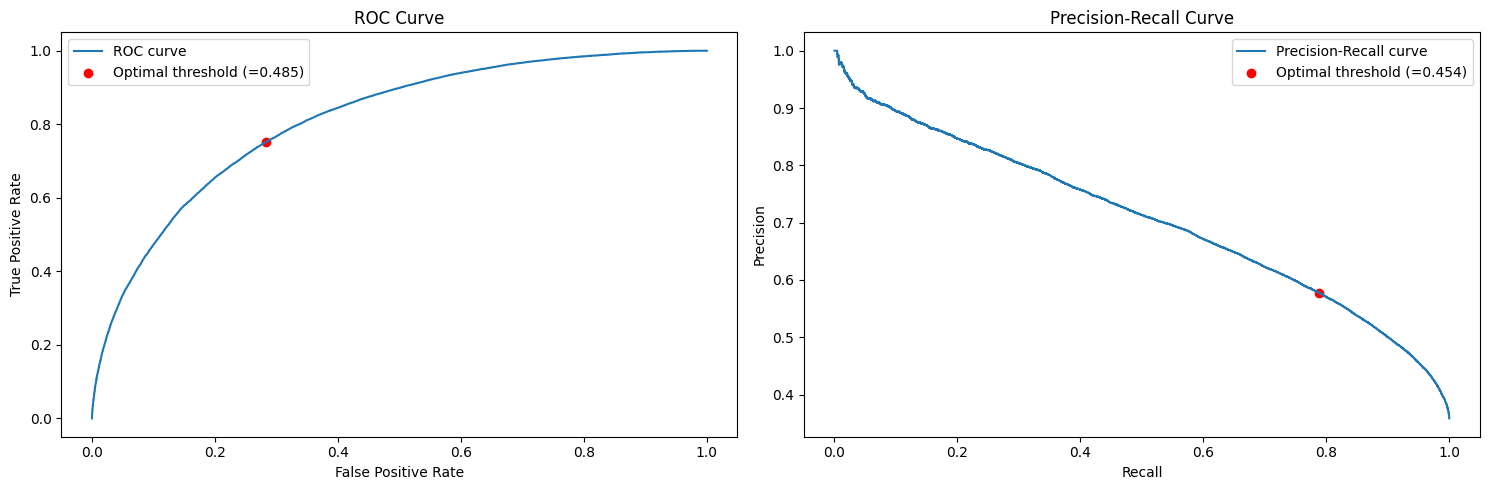

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[youden_idx], tpr[youden_idx], color='red',
            label=f'Optimal threshold (={optimal_threshold_roc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall[:-1], precision[:-1], label='Precision-Recall curve')
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red',
            label=f'Optimal threshold (={optimal_threshold_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
y_pred_roc = (y_probs >= optimal_threshold_roc).astype(int)
y_pred_pr = (y_probs >= optimal_threshold_pr).astype(int)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     68272
           1       0.61      0.73      0.66     38150

    accuracy                           0.73    106422
   macro avg       0.72      0.73      0.72    106422
weighted avg       0.75      0.73      0.74    106422



In [16]:
print(classification_report(y_test, y_pred_roc))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77     68272
           1       0.60      0.75      0.67     38150

    accuracy                           0.73    106422
   macro avg       0.72      0.73      0.72    106422
weighted avg       0.75      0.73      0.73    106422



In [17]:
print(classification_report(y_test, y_pred_pr))

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     68272
           1       0.58      0.79      0.67     38150

    accuracy                           0.72    106422
   macro avg       0.71      0.73      0.71    106422
weighted avg       0.75      0.72      0.72    106422



In [18]:
joblib.dump(vectorizer, '../models/vectorizer.joblib')
joblib.dump(svd, '../models/svd.joblib')
joblib.dump(best_model, '../models/model.joblib')

['../models/model.joblib']

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  
    return text.split()

df['tokens'] = df['text'].apply(preprocess_text)

In [22]:
EMBEDDING_DIM = 300
w2v = Word2Vec(sentences=df['tokens'], vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4)

In [23]:
word2idx = {word: idx+1 for idx, word in enumerate(w2v.wv.index_to_key)}  # +1 для PAD=0
word2idx['<PAD>'] = 0
embedding_matrix = np.zeros((len(word2idx), EMBEDDING_DIM))
for word, idx in word2idx.items():
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]

In [24]:
MAX_LEN = 50

def encode(tokens):
    idxs = [word2idx.get(w, 0) for w in tokens]
    if len(idxs) < MAX_LEN:
        idxs += [0] * (MAX_LEN - len(idxs))
    else:
        idxs = idxs[:MAX_LEN]
    return idxs

df['input_ids'] = df['tokens'].apply(encode)

X_train, X_test, y_train, y_test = train_test_split(df['input_ids'].tolist(), df['label'].tolist(), test_size=0.2)

In [25]:
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.X = torch.tensor(inputs, dtype=torch.long)
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train, y_train)
test_ds = TextDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256)

In [26]:
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, n_classes, n_heads=4, hidden_dim=128, n_layers=2):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Linear(embed_dim, n_classes)
    
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)               
        embedded = embedded.permute(1, 0, 2)              
        out = self.transformer(embedded)                   
        out = out.mean(dim=0)                              
        return self.classifier(out)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(embedding_matrix, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [28]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [06:22<00:00,  8.69it/s]


Epoch 1: Loss = 1312.5179


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [06:22<00:00,  8.70it/s]


Epoch 2: Loss = 1145.1112


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [06:19<00:00,  8.76it/s]


Epoch 3: Loss = 1038.9276


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [06:21<00:00,  8.71it/s]


Epoch 4: Loss = 975.5020


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [05:32<00:00,  9.99it/s]


Epoch 5: Loss = 931.0844


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [05:09<00:00, 10.74it/s]


Epoch 6: Loss = 892.8058


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [05:09<00:00, 10.76it/s]


Epoch 7: Loss = 857.7127


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [05:09<00:00, 10.73it/s]


Epoch 8: Loss = 832.4280


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [05:09<00:00, 10.76it/s]


Epoch 9: Loss = 804.2952


100%|██████████████████████████████████████████████████████████████████████████████| 3326/3326 [05:09<00:00, 10.76it/s]

Epoch 10: Loss = 784.1645


In [29]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = torch.argmax(model(X_batch), dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.8209


In [30]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86    136287
           1       0.76      0.73      0.75     76556

    accuracy                           0.82    212843
   macro avg       0.81      0.80      0.80    212843
weighted avg       0.82      0.82      0.82    212843

